In [29]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import spatial
from utilities import load_data, print_features, print_predictions
from sklearn.decomposition import PCA

%matplotlib inline

plt.rc('figure', figsize=(10, 4), dpi=110)
plt.rc('font', size=10)

# you may use these colours to produce the scatter plots
CLASS_1_C = r'#3366ff'
CLASS_2_C = r'#cc3300'
CLASS_3_C = r'#ffc34d'

In [48]:
train_set, train_labels, test_set, test_labels = load_data(train_set_path="data/wine_train.csv", 
                                                           train_labels_path="data/wine_train_labels.csv",
                                                           test_set_path="data/wine_test.csv",
                                                           test_labels_path="data/wine_test_labels.csv")

def plot_coloured(ax, data, labels):
    for n in range(len(labels)):
        ax.scatter(data[n, 0], data[n, 1], color = class_colours[int(labels[n]) - 1])
        
def run_knn(train_set, train_labels, test_set, k):
    results = []

    for point in test_set:
        distances = [ spatial.distance.euclidean(point, neighbor) for neighbor in train_set ]

        neighbors = []
        for i in range(k):
            closest = np.argmin(distances)

            neighbors.append(train_labels[closest])
            distances[closest] = float("inf")

        counts = np.bincount(neighbors)
        most_common = np.argmax(counts)

        results.append(most_common)

    return results

features = [6, 9]
features_3d = [6, 9, 10]

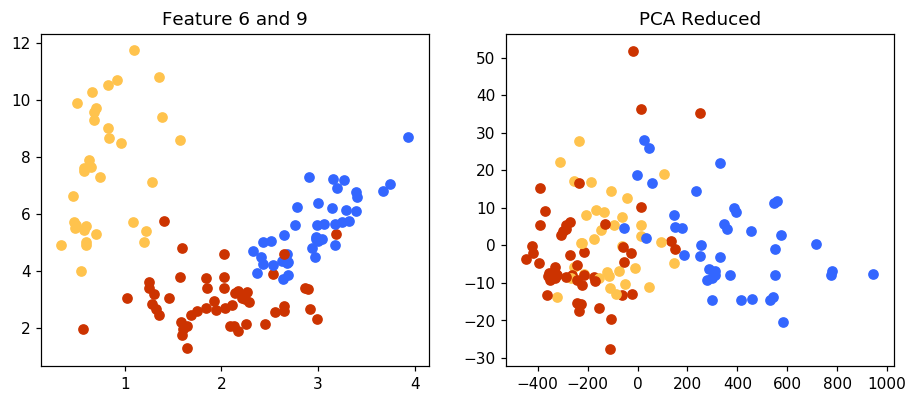

In [42]:
pca = PCA(n_components = 2)

train_set_r = pca.fit_transform(train_set)
test_set_r = pca.transform(test_set)

fig, ax = plt.subplots(1, 2)

ax[0].set_title("Feature 6 and 9")
data = np.column_stack((train_set[:, features[0]], train_set[:, features[1]]))
plot_coloured(ax[0], data, train_labels)

ax[1].set_title("PCA Reduced")
plot_coloured(ax[1], train_set_r, train_labels)

plt.show()

<Figure size 1100x440 with 0 Axes>

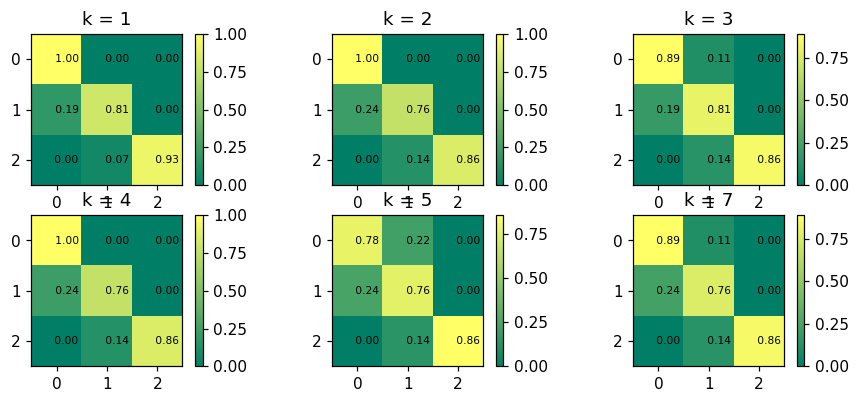

In [80]:
def calculate_confusion_matrix(gt_labels, pred_labels):
    gt_labels = gt_labels.astype(int)
    pred_labels = np.asarray(pred_labels)
    
    cm = np.zeros((3, 3))
    
    num_classes = max(len(set(gt_labels)), len(set(pred_labels)))
   
    for i in range(num_classes):
        gt = gt_labels[gt_labels == i + 1]
        pred = pred_labels[gt_labels == i + 1]
        
        for j in range(num_classes):
            cm[i, j] = len(pred[pred == j + 1]) / len(gt)
            
    
    return cm

def plot_matrix(matrix, ax):  
    handle = ax.imshow(matrix, cmap = plt.get_cmap('summer'))
    plt.colorbar(handle, ax = ax)
    
    for (j, i), label in np.ndenumerate(matrix):
        ax.text(i, j, "{:10.2f}".format(label), ha='center', va='center', fontsize='x-small')

train_set_r = np.column_stack((train_set[:, features[0]], train_set[:, features[1]]))
test_set_r = np.column_stack((test_set[:, features[0]], test_set[:, features[1]]))


plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.01, hspace=0.2)

fig, ax = plt.subplots(2, 3)
ks = [1, 2, 3, 4, 5, 7]

x = 0
for k in ks:
    a = ax[x // 3, x % 3]
    
    a.set_title(f"k = { k }")
    predictions = run_knn(train_set_r, train_labels, test_set_r, k)

    cm = calculate_confusion_matrix(test_labels, predictions)
    plot_matrix(cm, a)
    
    x += 1

plt.show()